In [530]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [466]:
import math
import friendlywords
import random
import numpy as np
import matplotlib.pyplot as plt
import dataclasses
import functools as FT
import tqdm

import typing as T
from typing import Callable
from typing import Optional

### Understanding diff with rise over run

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5


def dfdx(x):
    return 6*x - 4

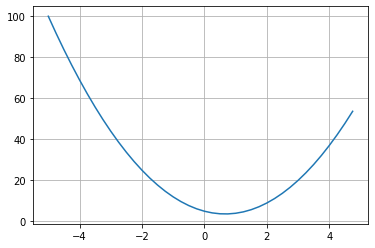

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.grid()

In [5]:
h=0.0000000001
x=3
# sign is positive
(f(x+h)-f(x))/h

14.000001158365194

In [6]:
x=-3
# sign is positive
(f(x+h)-f(x))/h

-21.999966293151374

In [7]:
x=2/3
# zero minimum, at the exact point nudging doesn't
# affect output
(f(x+h)-f(x))/h

0.0

In [8]:
a = 2.0
b = -3.0
c = 10.0
def d_fn(a,b,c):
    return a*b + c
print(d_fn(a,b,c))

4.0


In [9]:
h = 0.0001
d1 = d_fn(a,b,c)
d2 = d_fn(a+h,b,c)
(d2-d1)/h

-3.000000000010772

In [10]:
(d_fn(a,b+h,c)-d_fn(a,b,c))/h

2.0000000000042206

In [11]:
(d_fn(a,b,c+h)-d_fn(a,b,c))/h

0.9999999999976694

### Defining the Value Node which can be backpropped through

In [ ]:
b = a^n
db/da = n*a^(n-1) 

In [489]:
@dataclasses.dataclass
class Value:
    
    data: float
    backward: [Callable] = dataclasses.field(init=False)
    label: Optional[str] = dataclasses.field(default_factory=lambda: f"tmp_{friendlywords.generate(1)}")
    grad: float = 0.
    # operands which generated this node
    _prev: set['Value'] = dataclasses.field(default_factory=set)
    # operation that created this node
    _op: Optional[str] = None
    # leaf input nodes should have no grad fn
    _backward: [Callable] = lambda: None
    
    def __post_init__(self):
        self.backward = FT.partial(backward, node=self)
        
    def __add__(self, other: T.Union['Value', float]) -> 'Value':
        other = _make_node(maybe_value=other)
        out = Value(
            data=self.data + other.data,
            _prev=set((self, other)),
            _op='+',
        )
        out._backward = FT.partial(
            Value._add_backward,
            v1=self,
            v2=other,
            out=out,
        )
        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return -1*self
    
    def __sub__(self, other):
        return self + (-other)
    
    def __rsub__(self, other):
        return other + (-self)
    
    
    @staticmethod
    def _add_backward(v1, v2, out):
        v1.grad += out.grad
        v2.grad += out.grad
    
    def __mul__(self, other: T.Union['Value', float]) -> 'Value':
        other = _make_node(maybe_value=other)
        out = Value(
            data=self.data * other.data,
            _prev=set((self, other)),
            _op='*',
        )
        out._backward = FT.partial(
            Value._mul_backward,
            v1=self,
            v2=other,
            out=out,
        )
        return out
    
    def __rmul__(self, other):
        return self * other

    @staticmethod
    def _mul_backward(v1, v2, out):
        v1.grad += v2.data * out.grad
        v2.grad += v1.data * out.grad

    def __pow__(self, other: T.Union[float, int]) -> 'Value':
        assert isinstance(other, (float, int)), "Only scalar pow supported"
        out = Value(
            data=self.data ** other,
            _prev=set([self]),
            _op=f'^({other})',
            label=f'{self.label}^({other})'
        )
        out._backward = FT.partial(
            Value._pow_backward,
            v=self,
            out=out,
            exponent=other,
        )
        return out
    
    @staticmethod
    def _pow_backward(v: 'Value', out: 'Value', exponent: T.Union[float, int]):
        v.grad += exponent * (v.data**(exponent-1)) * out.grad

    def __truediv__(self, other):
        return self * (other**(-1))

    
    def tanh(self) -> 'Value':
        out = Value(
            data=tanh(x=self.data),
            label=f'tanh({self.label}(data={self.data}))',
            _prev=set([self]),
            _op='tanh',
        )
        out._backward = FT.partial(
            Value._tanh_backward, v=self, out=out,
        )
        return out
    
    def exp(self):
        x = self.data
        out = Value(data=math.exp(x), _prev={self}, _op="exp", label=f'exp({self.label})')
        out._backward = FT.partial(Value._exp_backward, v=self, out=out)
        return out
    
    @staticmethod
    def _tanh_backward(v, out):
        v.grad += (1 - tanh(v.data)**2) * out.grad

    @staticmethod
    def _exp_backward(v, out):
        v.grad += out.data * out.grad

    def __hash__(self):
        return hash(str(id(self)))
        
    def __repr__(self) -> str:
        return f"Value(label={self.label}, data={self.data}, grad={self.grad})"


def _make_node(maybe_value: T.Union[Value, float]) -> Value:
    if isinstance(maybe_value, Value):
        return maybe_value
    else:
        return Value(data=maybe_value)


def backward(node: Value) -> None:
    """Performs back prop through the node"""
    for n in topological_sort(node):
        n._backward()


def topological_sort(node: Value) -> list[Value]:
    """Topological sort such that each element in the output list
    depends on (_prev) nodes which come after it.
    """
    output = []
    seen = set()
    _topsort_rec(node=node, output=output, seen=seen)
    return list(reversed(output))

def _topsort_rec(node: Value, output: list[Value], seen=set[Value]) -> None:
    seen.add(node)
    for p in node._prev:
        if p not in seen:
            _topsort_rec(node=p, output=output, seen=seen)
    output.append(node)
    
    

def tanh(x: float) -> float:
    me = math.exp(2*x)
    return (me -1) / (me+1)

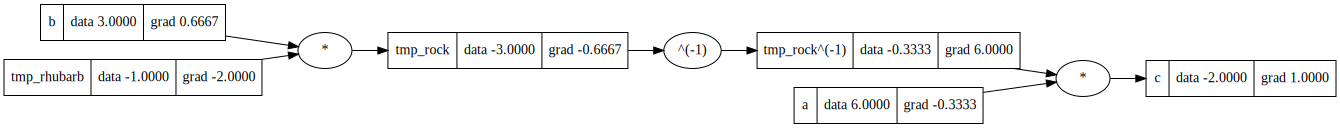

In [490]:
a = Value(6., label='a')
b = Value(3., label='b')
c = a/(-b)
c.label = 'c'

c.grad = 1 
c.backward()
draw_dot(c)

In [491]:
a = Value(2., label='a')
b = Value(-3., label='b')
c = Value(10., label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f =  Value(-2., label='f')
L = d * f; L.label = 'L'
print(f"{L=}, {L.grad=}, {L._prev=}, {L._op=}")

L=Value(label=L, data=-8.0, grad=0.0), L.grad=0.0, L._prev={Value(label=f, data=-2.0, grad=0.0), Value(label=d, data=4.0, grad=0.0)}, L._op='*'


In [492]:
a.exp()

Value(label=exp(a), data=7.38905609893065, grad=0.0)

### Visualisation code

In [493]:
from graphviz import Digraph


def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    return dot

#### Manually check gradients

In [494]:
a.grad = 6.
b.grad = -4.
c.grad = -2.
e.grad = -2.
d.grad = -2.
f.grad = 4.
L.grad = 1

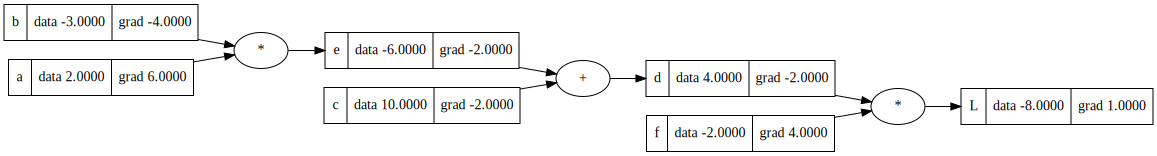

In [495]:
draw_dot(L)

In [496]:
def lol():
    """Gradient checking"""
    h = 0.0001
    a = Value(2., label='a')
    b = Value(-3., label='b')
    c = Value(10., label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f =  Value(-2., label='f')
    L1 = (d * f).data

    a = Value(2., label='a')
    b = Value(-3.+h, label='b')
    c = Value(10., label='c')
    e = a*b; e.label = 'e'
    d = e + c; d.label = 'd'
    f =  Value(-2., label='f')
    L2 = (d * f).data
    
    return (L2-L1)/h

lol()

-4.000000000008441

### Backprop through a single neuron

In [497]:
def tanh_simple():
    # inputs x1,x2
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    o = n.tanh(); o.label = 'o'
    return o

#### Forward propagation

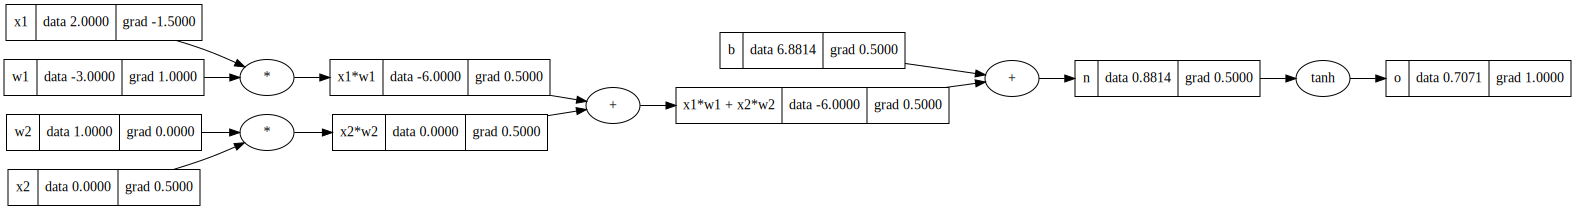

In [498]:
o = tanh_simple()
o.grad = 1
o.backward()
draw_dot(o)

#### Backpropagation

In [499]:
def tanh_with_exp():
    # inputs x1,x2
    x1 = Value(2.0, label='x1')
    x2 = Value(0.0, label='x2')
    # weights w1,w2
    w1 = Value(-3.0, label='w1')
    w2 = Value(1.0, label='w2')
    # bias of the neuron
    b = Value(6.8813735870195432, label='b')
    # x1*w1 + x2*w2 + b
    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'
    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    e = (2*n).exp(); e.label = 'exp(2*n)'
    o = (e - 1) / (e + 1)
    o.label = 'o'
    return o

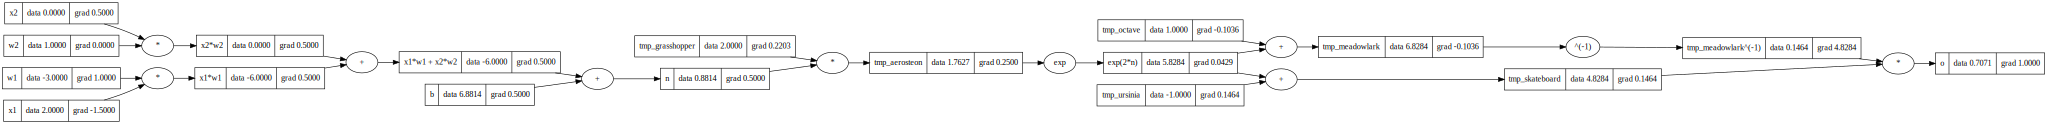

In [500]:
o = tanh_with_exp()
o.grad = 1
o.backward()
draw_dot(o)

In [501]:
import torch

In [502]:
import torch

x1 = torch.Tensor([2.0]); x1.requires_grad=True
x2 = torch.Tensor([0.0]); x2.requires_grad=True
w1 = torch.Tensor([-3.0]); w1.requires_grad=True
w2 = torch.Tensor([1.0]); w2.requires_grad=True
b = torch.Tensor([6.8814]); b.requires_grad=True
o = torch.tanh(x1*w1+x2*w2+b);
print(o.item())
o.backward()
print(f"{x1.grad=}, {x2.grad=}, {w1.grad=}, {w2.grad=}")

0.7071200609207153
x1.grad=tensor([-1.4999]), x2.grad=tensor([0.5000]), w1.grad=tensor([1.0000]), w2.grad=tensor([0.])


In [559]:
@dataclasses.dataclass
class Neuron:
    num_input: int
    w: list[Value] = dataclasses.field(init=False)
    b: Value = dataclasses.field(init=False)
    params: list[Value] = dataclasses.field(init=False)
    
    def __post_init__(self):
        self.w = [Value(random.uniform(-1,1)) for _ in range(self.num_input)]
        self.b = Value(random.uniform(-1,1))
        self.params = self.w + [self.b]
    
    def __call__(self, x):
        return sum((xi*wi for xi, wi in zip(x, self.w)), self.b).tanh()

@dataclasses.dataclass
class Layer:
    num_input: int
    num_output: int
    neurons: list[Neuron] = dataclasses.field(init=False)
    params: list[Value] = dataclasses.field(init=False)
                   
    def __post_init__(self):
        self.neurons = [Neuron(num_input=self.num_input) for _ in range(self.num_output)]
        self.params = [p for n in self.neurons for p in n.params]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs


@dataclasses.dataclass
class MLP:
    num_input: int
    layer_dims: list[int]
    layers: list[Layer] = dataclasses.field(init=False)         

    def __post_init__(self):
        dims = [self.num_input] + self.layer_dims
        self.layers = [Layer(num_in, num_out) for num_in, num_out in zip(dims[:-1], dims[1:])]
        self.params = [p for lyr in self.layers for p in lyr.params]
        
    def __call__(self, x):
        o = x
        for lyr in self.layers:
            o = lyr(x=o)
        return o

In [560]:
x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(label=tanh(tmp_caribou(data=0.2739278200821473)), data=0.26727588037601485, grad=0.0)

In [561]:
len(n.params)

41

In [562]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [563]:
def grad_desc(mlp, xs, ys, num_iter=100, lr=0.1):
    loss = Value(data=np.inf)
    for i in (pbar := tqdm.notebook.tqdm(range(num_iter))):
        # fwd pass
        pbar.set_description(f"loss={loss.data}")
        ypred = [mlp(x) for x in xs]
        loss = sum((yp-yt)**2 for yp, yt in zip(ypred, ys))
        # zero grading
        for p in mlp.params:
            p.grad = 0
        # backward pass
        loss.grad = 1
        loss.backward()
        # grad desc
        for p in mlp.params:
            p.data -= lr * p.grad

In [564]:
[mlp(x) for x in xs]

[Value(label=tanh(tmp_asteroid(data=0.2739278200821473)), data=0.26727588037601485, grad=0.0),
 Value(label=tanh(tmp_emoji(data=0.7818546363054122)), data=0.6537699306109724, grad=0.0),
 Value(label=tanh(tmp_kite(data=0.7062248026252098)), data=0.6083040464211132, grad=0.0),
 Value(label=tanh(tmp_colossus(data=0.3626651552522786)), data=0.34755941214640984, grad=0.0)]

In [565]:
grad_desc(mlp=mlp, xs=xs, ys=ys)

  0%|          | 0/100 [00:00<?, ?it/s]

In [566]:
[mlp(x) for x in xs]

[Value(label=tanh(tmp_linen(data=2.1252500855141556)), data=0.9718866131271162, grad=0.0),
 Value(label=tanh(tmp_effect(data=-2.033550977976946)), data=-0.9663228837022784, grad=0.0),
 Value(label=tanh(tmp_form(data=-2.107265972372877)), data=-0.9708720141288281, grad=0.0),
 Value(label=tanh(tmp_barracuda(data=2.0729735683336554)), data=0.968836396821925, grad=0.0)]